In [16]:
# path to cellranger-outs and to save QCed object
path2outs='/nfs/team205/kk18/data/mapped/cellranger-arc101/'

## Import libraries

In [1]:
library(Signac)
library(Seurat)
library(EnsDb.Hsapiens.v86)
library(BSgenome.Hsapiens.UCSC.hg38)

set.seed(1234)
library(tidyverse)
library(patchwork)

Attaching SeuratObject


Attaching package: ‘Seurat’


The following object is masked from ‘package:Signac’:

    FoldChange


Loading required package: ensembldb

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
  

In [2]:
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.1 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.9.0
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.9.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    parallel  stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] patchwork_1.1.0                   forcats_0.5.0                    
 [3] stringr_1.4.0                     dplyr_1.0.2                      
 [5] purrr_0.3.4                       readr_1.4.0                      
 [7] tidyr_1.1.2         

## Read metadata

In [12]:
metadata = read.csv('/nfs/team205/kk18/data/cellatac/tic-1050/6reg-v2_Multiome_metadata.csv',row.names=1)
head(metadata)

,SangerID,SampleID,Protocol,Target,Donor,Region,Gender,Age,Type,cellranger_outs,Combined_ID
,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
0,HCAHeart9508819,A24-HEA-1-FTM-3,ATAC,10000,3,LV,Male,55-60,DBD,/seq/illumina/cellranger-arc/cellranger-arc101_count_cfab775b9eb6e3bb95ab801bf8098c53,HCAHeart9508627_HCAHeart9508819
1,HCAHeart9508820,A35-HEA-4-FTM-2,ATAC,10000,7,RA,Male,60-65,DCD,/seq/illumina/cellranger-arc/cellranger-arc101_count_9c3f804ef587b6de81a4976e5d800bd8,HCAHeart9508628_HCAHeart9508820
2,HCAHeart9508821,A35-HEA-1-FTM-2,ATAC,10000,7,LV,Male,60-65,DCD,/seq/illumina/cellranger-arc/cellranger-arc101_count_cb1d56b4e43e006dd32a8345c035f6c0,HCAHeart9508629_HCAHeart9508821
3,HCAHeart9508627,A24-HEA-1-FTM-3,RNA,10000,3,LV,Male,55-60,DBD,/seq/illumina/cellranger-arc/cellranger-arc101_count_cfab775b9eb6e3bb95ab801bf8098c53,HCAHeart9508627_HCAHeart9508819
4,HCAHeart9508628,A35-HEA-4-FTM-2,RNA,10000,7,RA,Male,60-65,DCD,/seq/illumina/cellranger-arc/cellranger-arc101_count_9c3f804ef587b6de81a4976e5d800bd8,HCAHeart9508628_HCAHeart9508820
5,HCAHeart9508629,A35-HEA-1-FTM-2,RNA,10000,7,LV,Male,60-65,DCD,/seq/illumina/cellranger-arc/cellranger-arc101_count_cb1d56b4e43e006dd32a8345c035f6c0,HCAHeart9508629_HCAHeart9508821


In [13]:
metadata$SangerID

[1] "HCAHeart9508819" "HCAHeart9508820" "HCAHeart9508821" "HCAHeart9508627"
 [5] "HCAHeart9508628" "HCAHeart9508629" "HCAHeart9845431" "HCAHeart9845432"
 [9] "HCAHeart9845433" "HCAHeart9845434" "HCAHeart9845435" "HCAHeart9845436"
[13] "HCAHeart9917173" "HCAHeart9917174" "HCAHeart9917175" "HCAHeart9917176"
[17] "HCAHeart9917177" "HCAHeart9917178"

## Signac workflow for Multiome

ref: https://satijalab.org/signac/articles/pbmc_multiomic.html

In [10]:
# get gene annotations for hg38
annotation <- GetGRangesFromEnsDb(ensdb = EnsDb.Hsapiens.v86)
seqlevelsStyle(annotation) <- "UCSC"
genome(annotation) <- "hg38"

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

Done

Fetching data...
OK

Parsing exons...
OK
Defining introns...
OK
Defining UTRs...
OK
Defining CDS...
OK

aggregating...

In [17]:
SangerIDs = metadata %>% filter(Protocol=='ATAC') %>% pull(SangerID)

for(ID in SangerIDs){
    print(ID)
    
    # load the RNA and ATAC data
    counts <- Read10X_h5(paste0(path2outs,ID,'/filtered_feature_bc_matrix.h5'))
    fragpath <- paste0(path2outs,ID,'/atac_fragments.tsv.gz')
    
    # create a Seurat object containing the RNA adata
    so <- CreateSeuratObject(
        counts = counts$`Gene Expression`,
        assay = "RNA"
    )
    
    # create ATAC assay and add it to the object
    so[["ATAC"]] <- CreateChromatinAssay(
        counts = counts$Peaks,
        sep = c(":", "-"),
        fragments = fragpath,
        annotation = annotation
    )
    
    print(dim(so))
    print(dim(so[["ATAC"]]))
          
    print('QCing')
    DefaultAssay(so) <- "ATAC"
    so <- NucleosomeSignal(so)
    so <- TSSEnrichment(so)
          
    saveRDS(so, paste0(path2outs,ID,'/',ID,'_SeuratObj_QCed.RDS'))
    rm(so)      
}

[1] "HCAHeart9508819"


Genome matrix has multiple modalities, returning a list of matrices for this genome

Computing hash



[1] 36601  3510
[1] 126052   3510
[1] "QCing"


Extracting TSS positions

Extracting fragments at TSSs


Computing TSS enrichment score



[1] "HCAHeart9508820"


Genome matrix has multiple modalities, returning a list of matrices for this genome

Computing hash



[1] 36601 11684
[1] 47014 11684
[1] "QCing"


Extracting TSS positions

Extracting fragments at TSSs


Computing TSS enrichment score



[1] "HCAHeart9508821"


Genome matrix has multiple modalities, returning a list of matrices for this genome

Computing hash



[1] 36601 10170
[1] 79543 10170
[1] "QCing"


Extracting TSS positions

Extracting fragments at TSSs


Computing TSS enrichment score



[1] "HCAHeart9917173"


Genome matrix has multiple modalities, returning a list of matrices for this genome

Computing hash



[1] 36601  5740
[1] 34208  5740
[1] "QCing"


Extracting TSS positions

Extracting fragments at TSSs


Computing TSS enrichment score



[1] "HCAHeart9917174"


Genome matrix has multiple modalities, returning a list of matrices for this genome

Computing hash



[1] 36601  2392
[1] 20819  2392
[1] "QCing"


Extracting TSS positions

Extracting fragments at TSSs


Computing TSS enrichment score



[1] "HCAHeart9917175"


Genome matrix has multiple modalities, returning a list of matrices for this genome

Computing hash



[1] 36601  4560
[1] 46286  4560
[1] "QCing"


Extracting TSS positions

Extracting fragments at TSSs


Computing TSS enrichment score



[1] "HCAHeart9917176"


Genome matrix has multiple modalities, returning a list of matrices for this genome

Computing hash



[1] 36601  5195
[1] 34804  5195
[1] "QCing"


Extracting TSS positions

Extracting fragments at TSSs


Computing TSS enrichment score



[1] "HCAHeart9917177"


Genome matrix has multiple modalities, returning a list of matrices for this genome

Computing hash



[1] 36601  5932
[1] 44400  5932
[1] "QCing"


Extracting TSS positions

Extracting fragments at TSSs


Computing TSS enrichment score



[1] "HCAHeart9917178"


Genome matrix has multiple modalities, returning a list of matrices for this genome

Computing hash



[1] 36601  5473
[1] 40219  5473
[1] "QCing"


Extracting TSS positions

Extracting fragments at TSSs


Computing TSS enrichment score



## QC visualisation

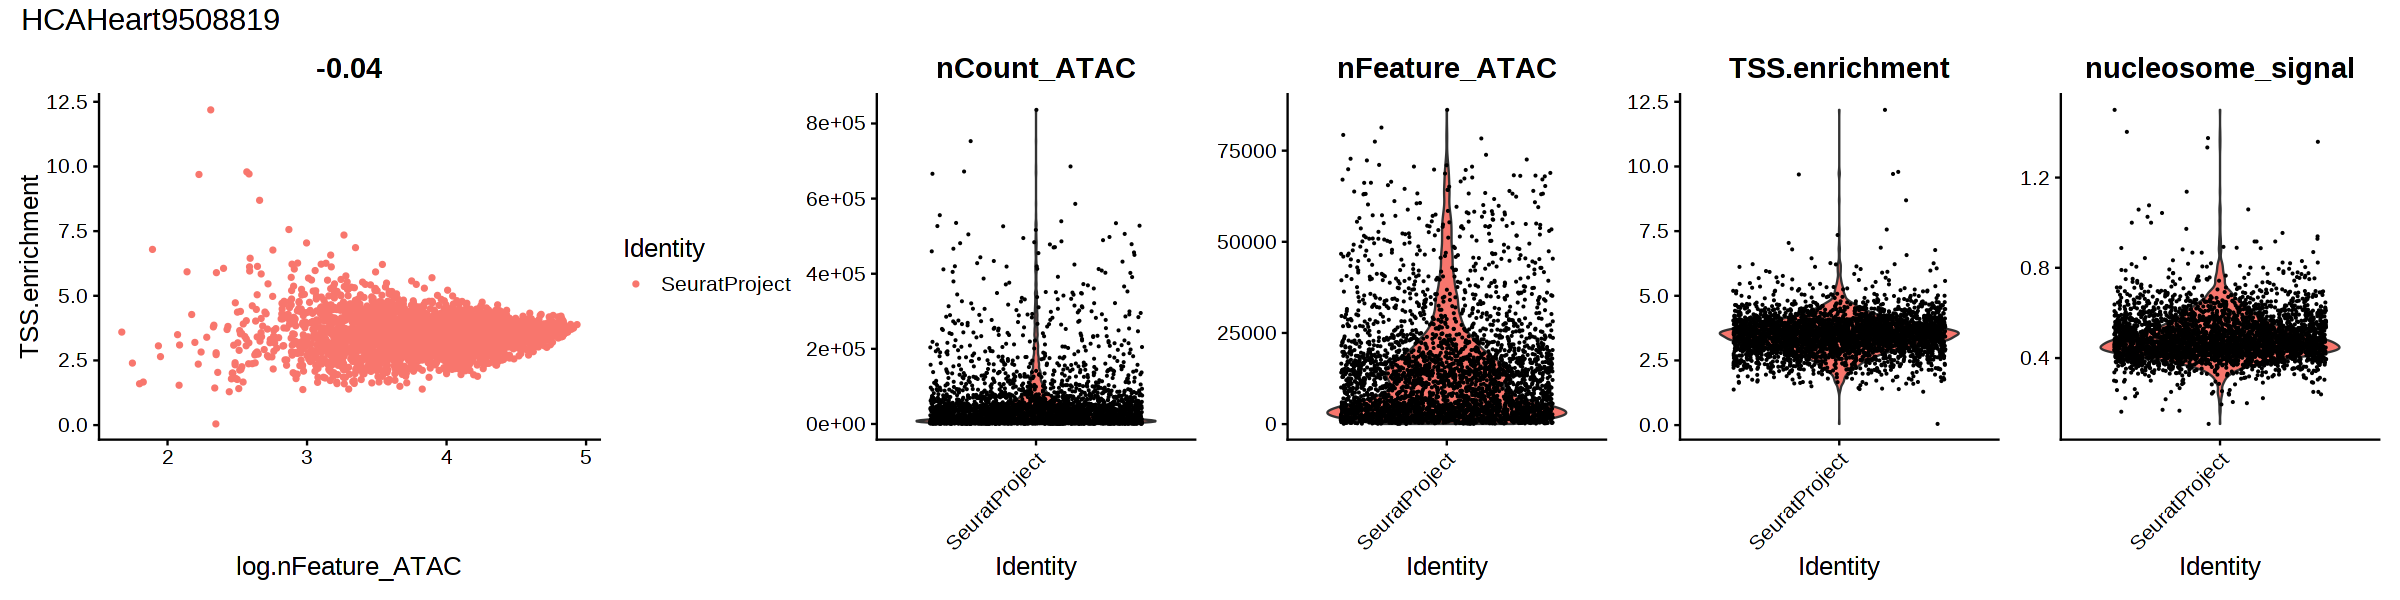

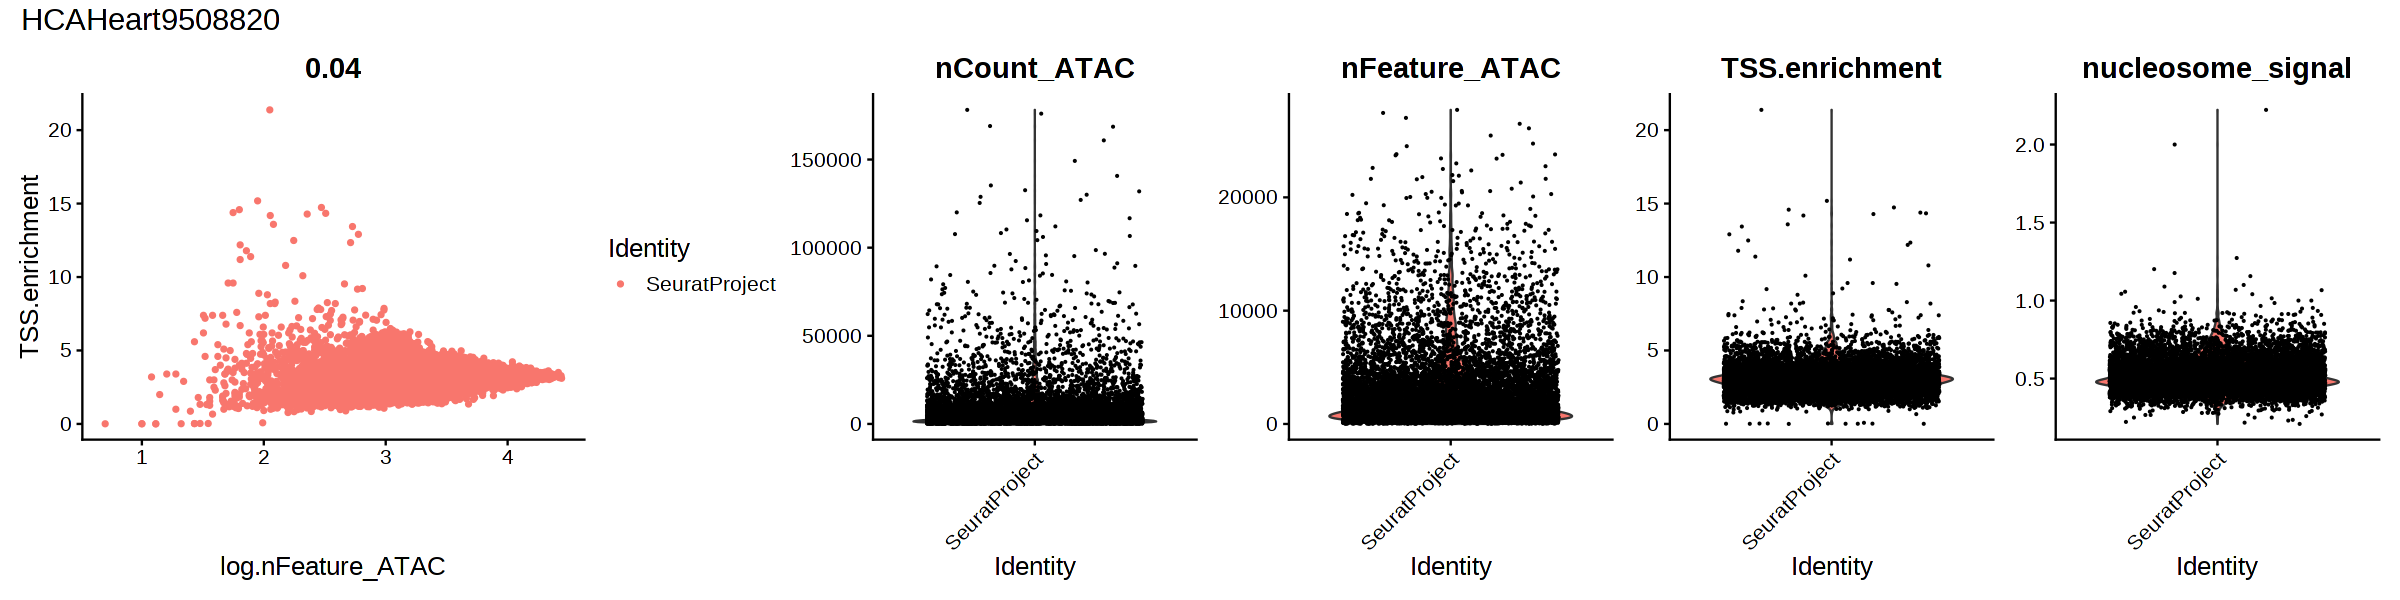

Warning message:
"Removed 7 rows containing non-finite values (stat_ydensity)."
Warning message:
"Removed 4 rows containing missing values (geom_point)."


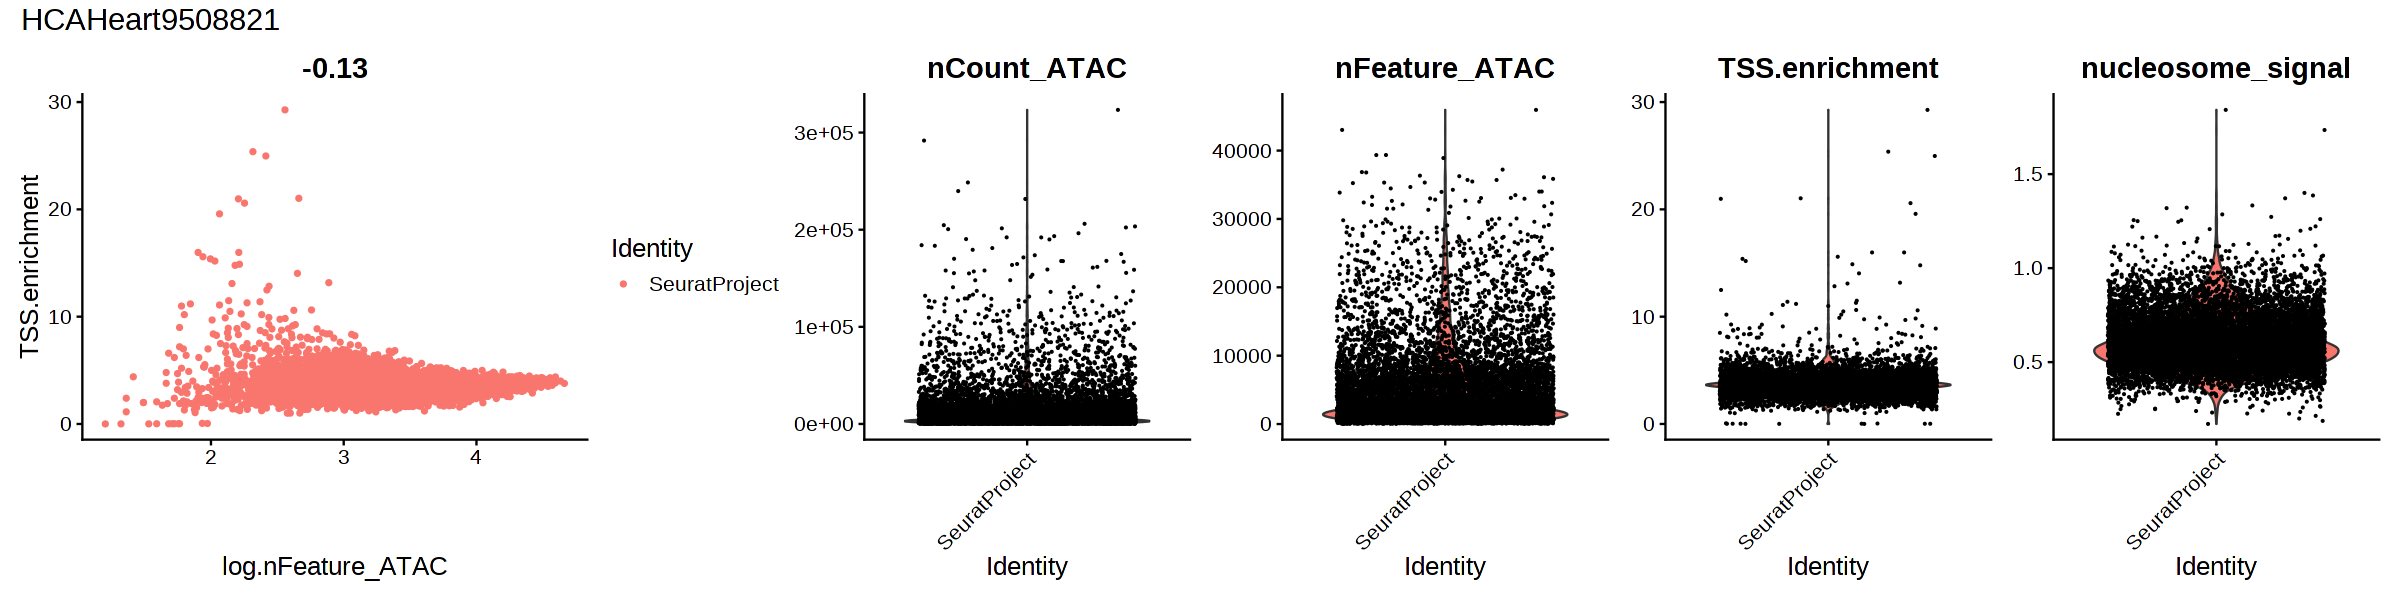

Warning message:
"Removed 3 rows containing non-finite values (stat_ydensity)."
Warning message:
"Removed 2 rows containing missing values (geom_point)."


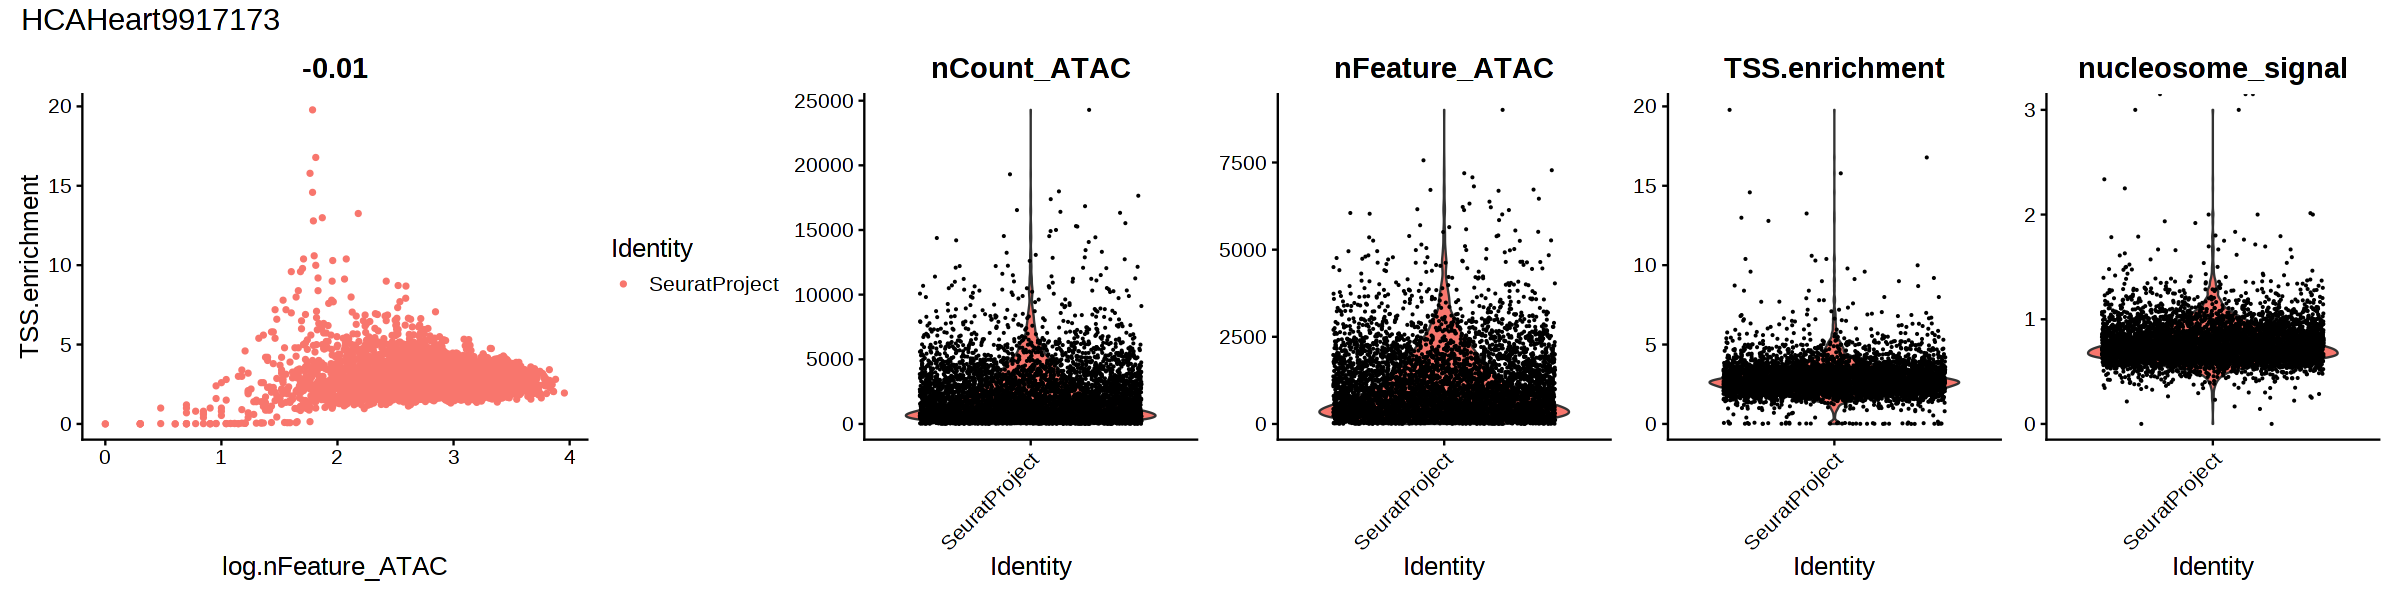

Warning message:
"Removed 1 rows containing non-finite values (stat_ydensity)."


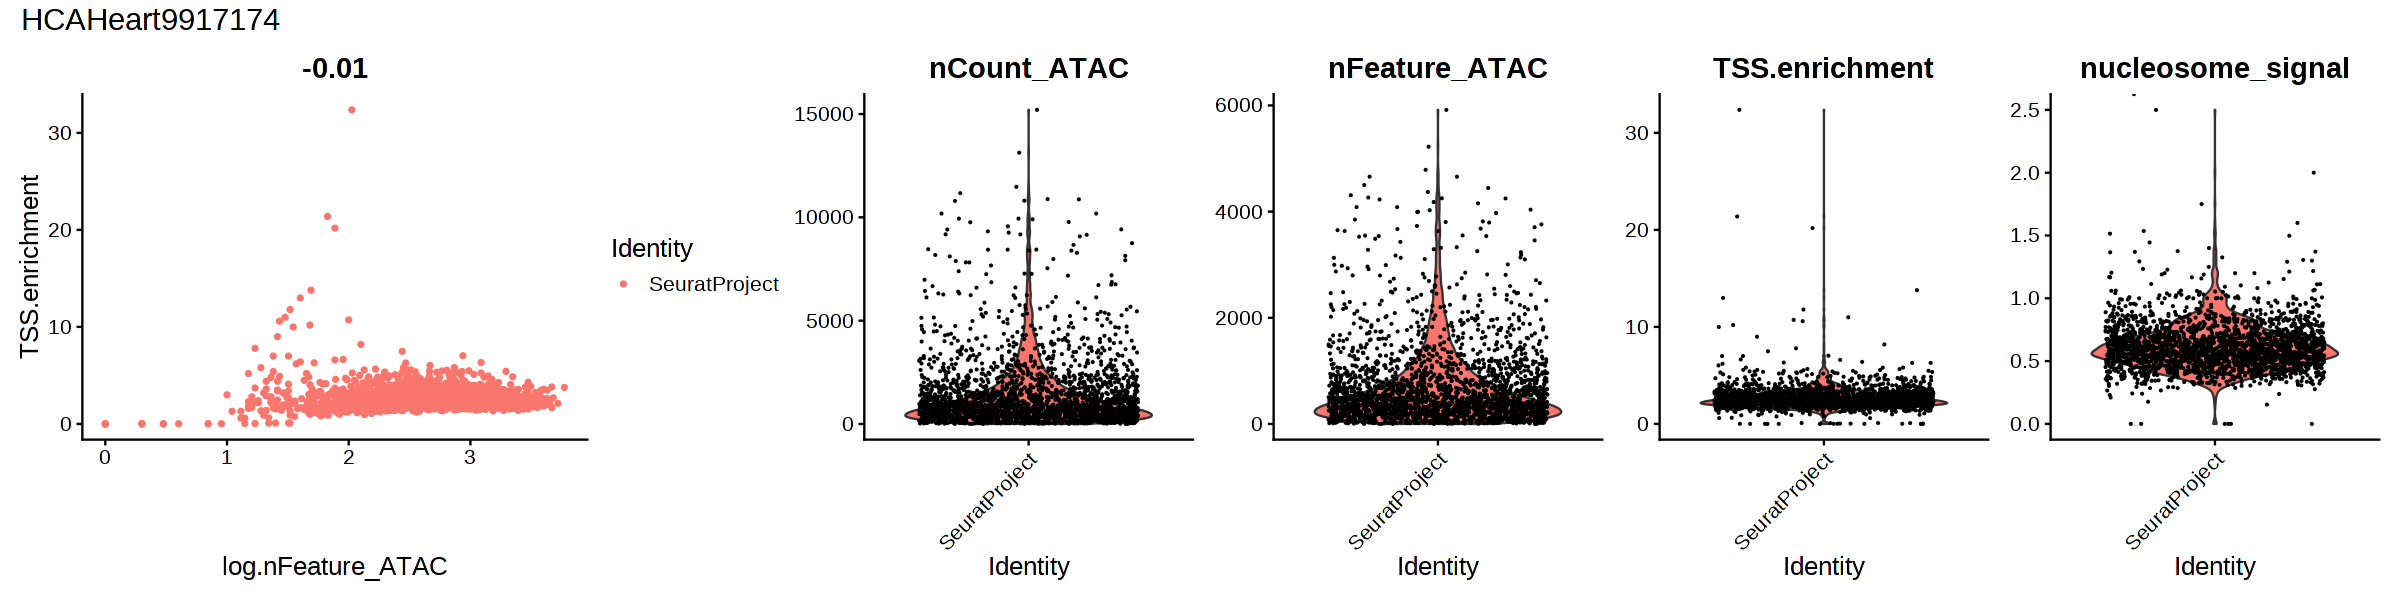

Warning message:
"Removed 7 rows containing non-finite values (stat_ydensity)."
Warning message:
"Removed 5 rows containing missing values (geom_point)."


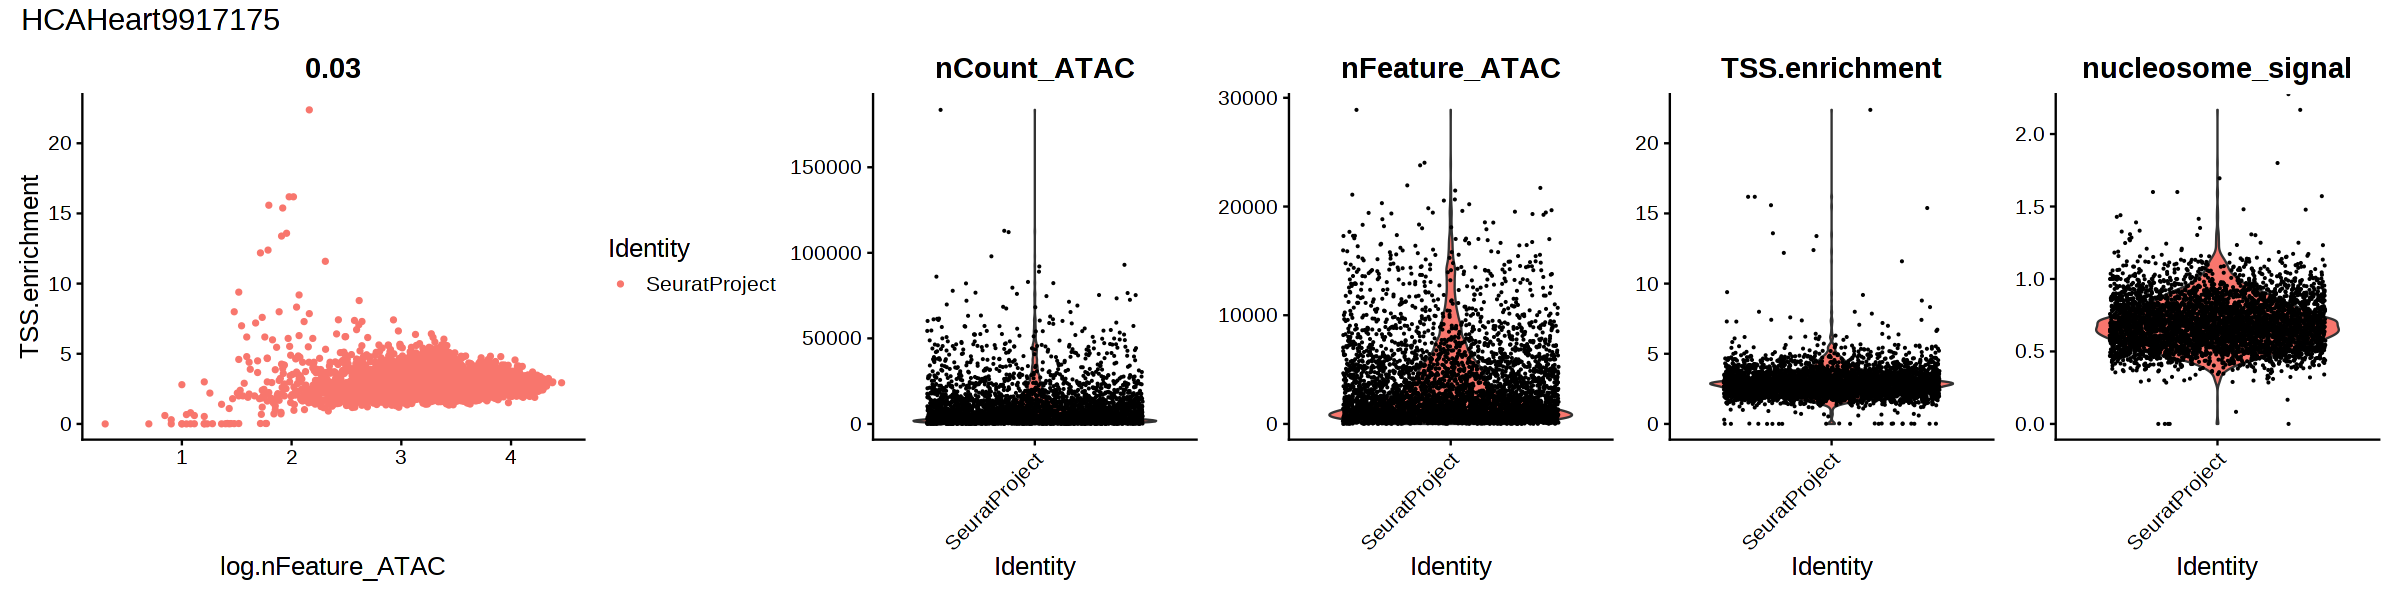

Warning message:
"Removed 2 rows containing non-finite values (stat_ydensity)."
Warning message:
"Removed 1 rows containing missing values (geom_point)."


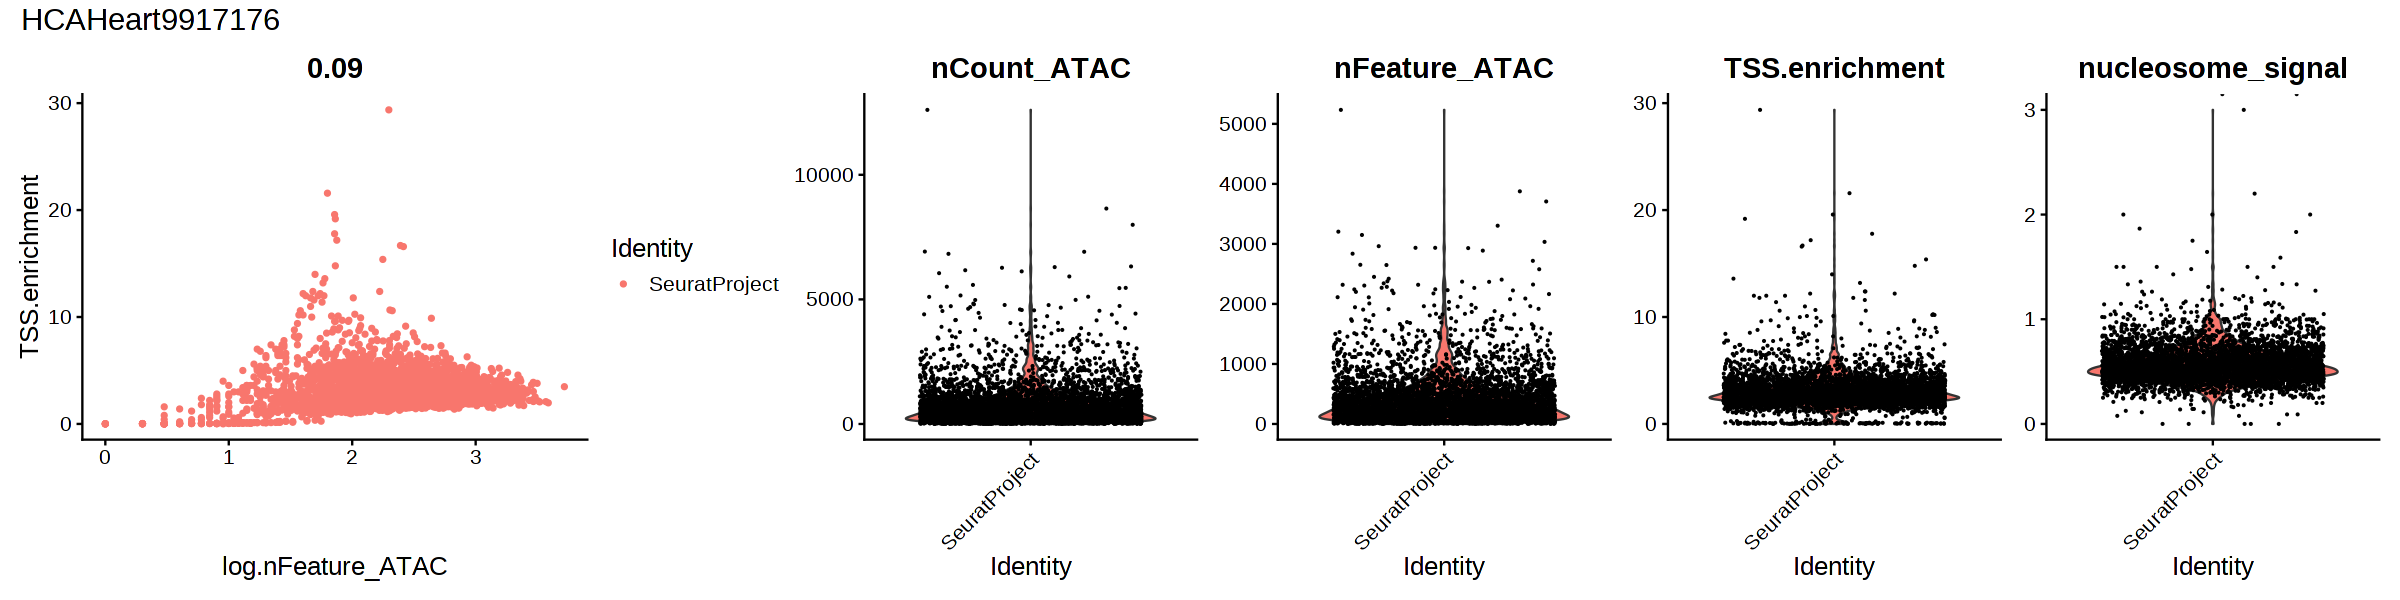

Warning message:
"Removed 2 rows containing non-finite values (stat_ydensity)."
Warning message:
"Removed 1 rows containing missing values (geom_point)."


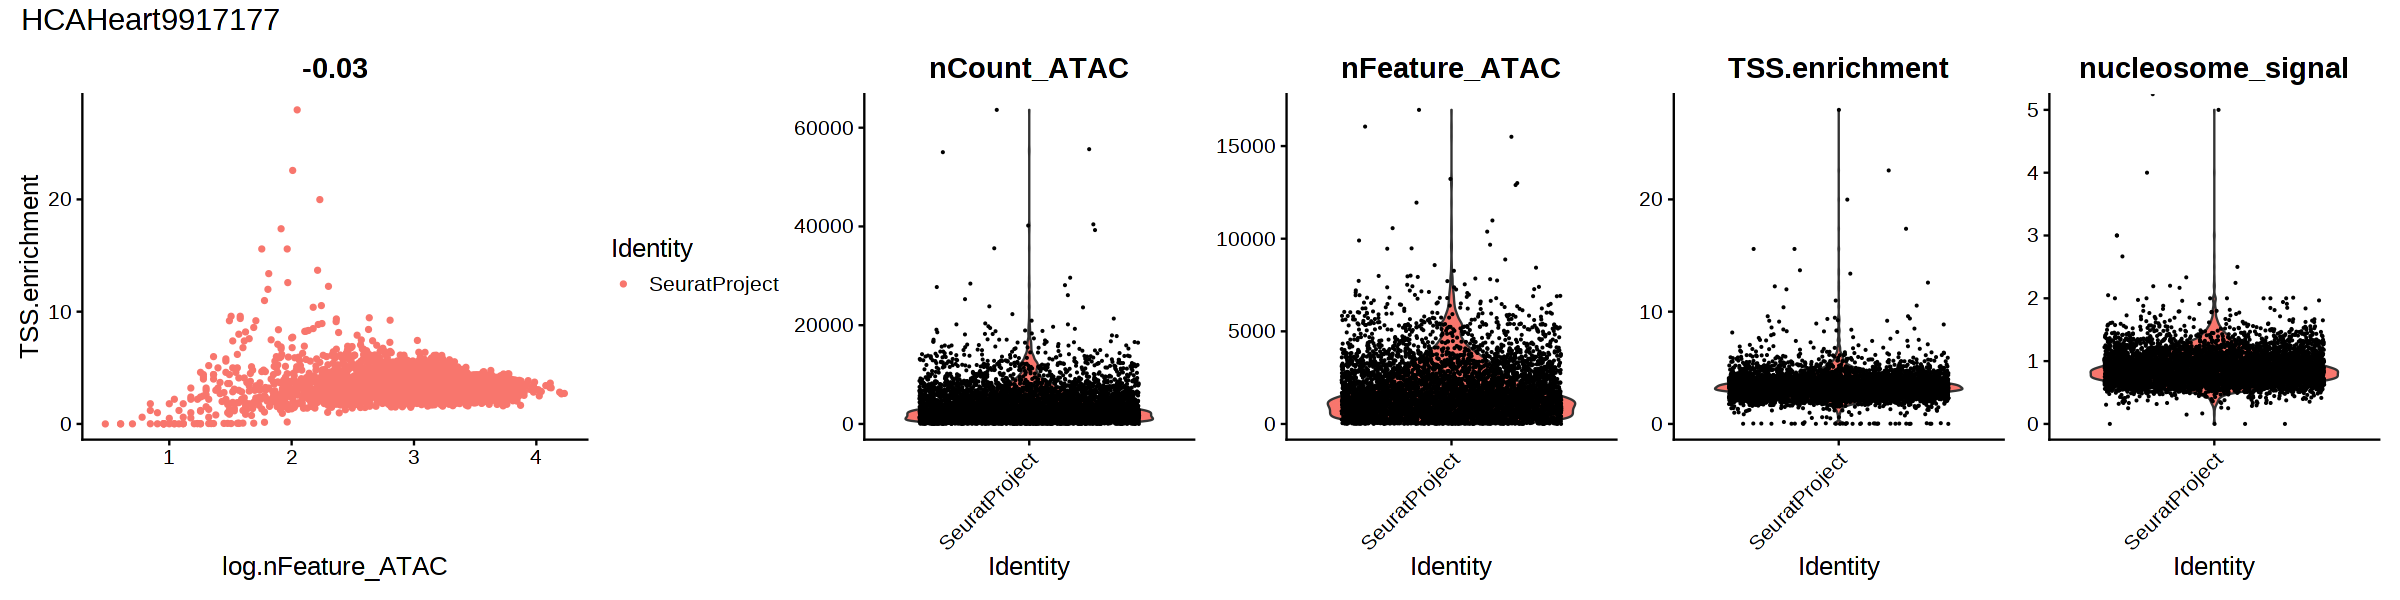

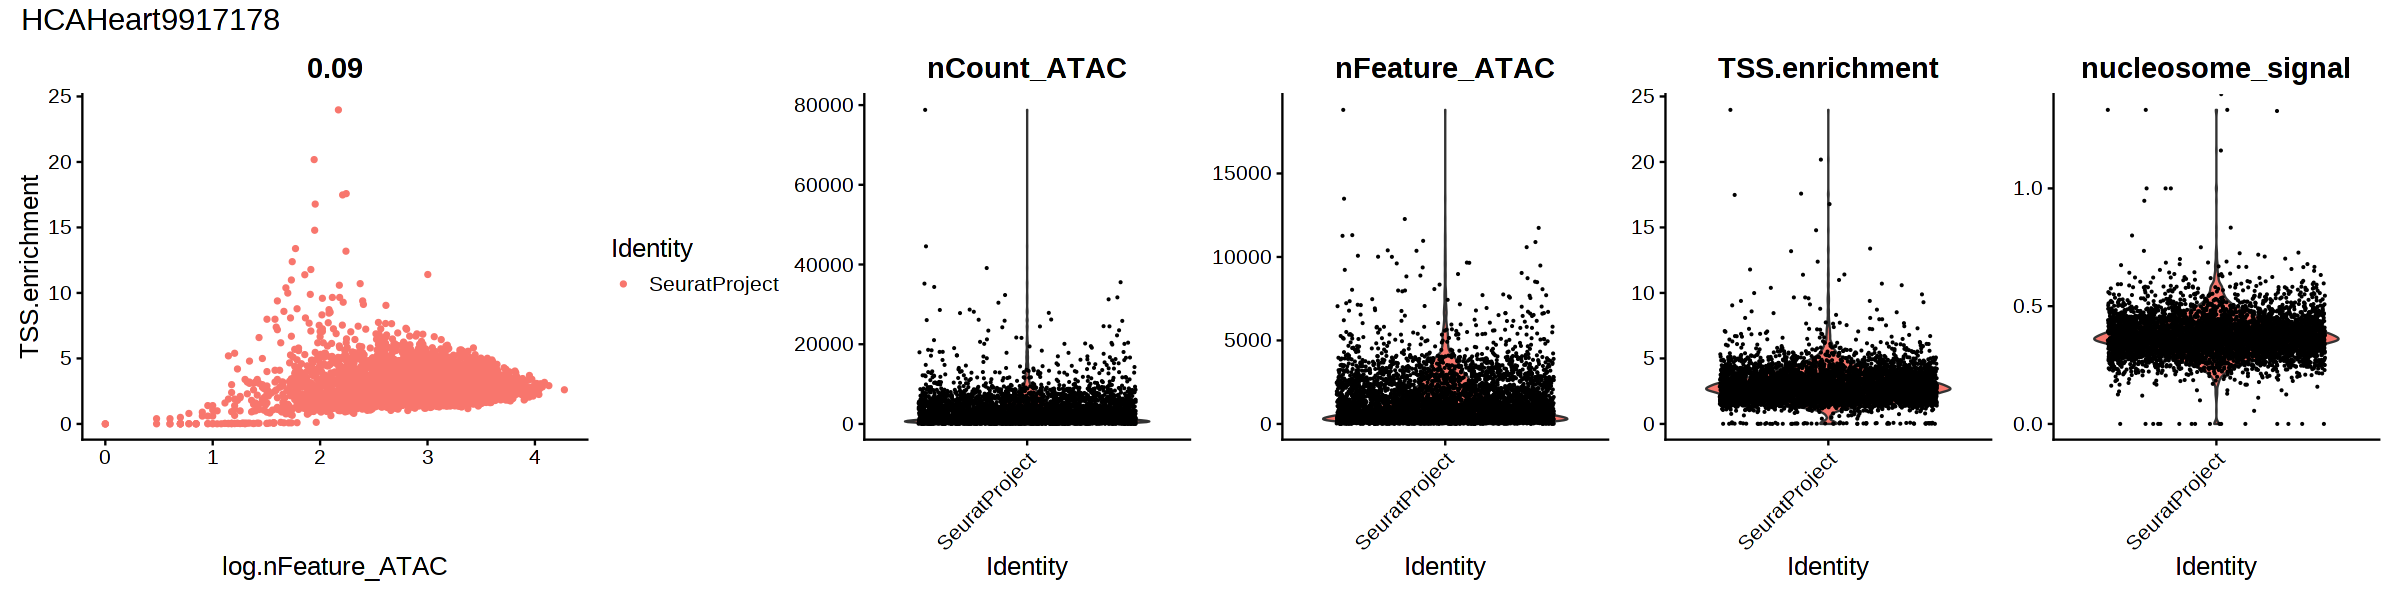

In [19]:
SangerIDs = metadata %>% filter(Protocol=='ATAC') %>% pull(SangerID)

options(repr.plot.width = 20, repr.plot.height = 5)
for(ID in SangerIDs){
    so = readRDS(paste0(path2outs,ID,'/',ID,'_SeuratObj_QCed.RDS'))
    DefaultAssay(so) <- "ATAC"
    so@meta.data$log.nFeature_ATAC=log10(so@meta.data$nFeature_ATAC)
    
    p1 = FeatureScatter(object = so, feature1 = 'log.nFeature_ATAC', feature2 = 'TSS.enrichment')
    p2 = VlnPlot(
        object = so,
        features = c('nCount_ATAC','nFeature_ATAC','TSS.enrichment','nucleosome_signal'),
        pt.size = 0.1,
        ncol = 4
    )
    P = p1+p2+plot_layout(nrow = 1, widths = c(1, 3))+plot_annotation(title = ID)&theme(title = element_text(size=15))
    plot(P)
}

## Filter out low quality cells and obtain good quality cell ID

In [20]:
SangerIDs = metadata %>% filter(Protocol=='ATAC') %>% pull(SangerID)

barcode=c()
for(ID in SangerIDs){
    print(ID)
    so = readRDS(paste0(path2outs,ID,'/',ID,'_SeuratObj_QCed.RDS'))
    DefaultAssay(so) <- "ATAC"
    
    print(dim(so[["ATAC"]]))
    so = subset(
        x = so,
        subset = TSS.enrichment>2 &
            nucleosome_signal<2 &
            nFeature_ATAC>1000
    )
    print(dim(so[["ATAC"]]))

    barcode=c(barcode, paste(ID, colnames(so[["ATAC"]]), sep='_'))
}

[1] "HCAHeart9508819"
[1] 126052   3510
[1] 126052   3274
[1] "HCAHeart9508820"
[1] 47014 11684
[1] 47014  7515
[1] "HCAHeart9508821"
[1] 79543 10170
[1] 79543  8310
[1] "HCAHeart9917173"
[1] 34208  5740
[1] 34208  2213
[1] "HCAHeart9917174"
[1] 20819  2392
[1] 20819   399
[1] "HCAHeart9917175"
[1] 46286  4560
[1] 46286  3070
[1] "HCAHeart9917176"
[1] 34804  5195
[1] 34804   304
[1] "HCAHeart9917177"
[1] 44400  5932
[1] 44400  3796
[1] "HCAHeart9917178"
[1] 40219  5473
[1] 40219  2229


In [21]:
length(barcode)

[1] 31110

In [23]:
# save the barcodes of good quality cells
write.table(barcode, file = "/nfs/team205/kk18/data/mapped/cellranger-arc101/6reg-v2_MultiomeATAC_Signac-QCed-barcodes.txt", col.names = F, row.names = F)

In [24]:
barcode = read.table(file = "/nfs/team205/kk18/data/mapped/cellranger-arc101/6reg-v2_MultiomeATAC_Signac-QCed-barcodes.txt", header=F)
barcode

V1
<chr>
HCAHeart9508819_AAACATGCAGCAGGTA-1
HCAHeart9508819_AAACATGCATAGCTGC-1
HCAHeart9508819_AAACCAACAAGGTGCA-1
HCAHeart9508819_AAACCAACACTTAACG-1
HCAHeart9508819_AAACCAACAGCCGCTA-1
HCAHeart9508819_AAACCAACATTATGCG-1
HCAHeart9508819_AAACCGAAGAATGACG-1
HCAHeart9508819_AAACCGAAGCCAGGTC-1
HCAHeart9508819_AAACCGAAGCCGGTAC-1
